# NOTES:
# - Made this alternate file just for a clearer version of the overall structure
# - changing physical activity to hours so that the coefficient in the end result is not too small
# - splitting data 70/30 before first VIF check 
# - using training set for first VIF check
# - using training set for final model fitting with stepAIC
# - only using testing set for later validation
# - "Occupation: Accountant" is absorbed into (Intercept) in stepAIC
# - therefore in the summary of the stepAIC, values for the rows for the levels of the occupation variables are produced in relation to the reference level "Accountant", and for all other rows the values are in association with the response variable
# - Not sure of validation is needed but included in case we need it

# LIBRARIES

In [1]:
library(tidyverse)
library(repr)
library(broom)
library(leaps)
library(moderndive)
library(MASS)
library(car)
library(rsample)
library(ggplot2)

print("LIBRARIES LOADED")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




[1] "LIBRARIES LOADED"


# DATA AND TIDYING

In [2]:
file_url <- "https://drive.google.com/uc?export=download&id=1ZjZvLl5dUzHEF8ouimlTg8t0MorhjzVA"
sleep_data <- read.csv(file_url)
head(sleep_data)
set.seed(114514) # SEED, DO NOT CHANGE

,Person.ID,Gender,Age,Occupation,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,BMI.Category,Blood.Pressure,Heart.Rate,Daily.Steps,Sleep.Disorder
,<int>,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


In [3]:
sleep_data_reduced <- sleep_data %>%
  dplyr::select(-any_of(c("Person.ID", "Gender", "Blood.Pressure", "Heart.Rate", "Daily.Steps")))
new_names <- c(
  "Age", "Occupation", "Sleep_Duration", 
  "Quality_of_Sleep", "Physical_Activity_Level", "Stress_Level", 
  "BMI_Category",
  "Sleep_Disorder"
)
names(sleep_data_reduced)<- new_names
sleep_data_reduced<- sleep_data_reduced|>mutate(BMI_Category = as.factor(BMI_Category), Occupation = as.factor(Occupation))
sleep_data_reduced<- sleep_data_reduced|>mutate(Sleep_Disorder= ifelse(Sleep_Disorder=="None", "False", "True"))
sleep_data_reduced<- sleep_data_reduced|>mutate(Sleep_Disorder = as.factor(Sleep_Disorder))
sleep_data_reduced <- sleep_data_reduced|>mutate(Physical_Activity_Level = Physical_Activity_Level / 60)
head(sleep_data_reduced) 
nrow(sleep_data_reduced)

,Age,Occupation,Sleep_Duration,Quality_of_Sleep,Physical_Activity_Level,Stress_Level,BMI_Category,Sleep_Disorder
,<int>,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>
1,27,Software Engineer,6.1,6,0.7,6,Overweight,False
2,28,Doctor,6.2,6,1.0,8,Normal,False
3,28,Doctor,6.2,6,1.0,8,Normal,False
4,28,Sales Representative,5.9,4,0.5,8,Obese,True
5,28,Sales Representative,5.9,4,0.5,8,Obese,True
6,28,Software Engineer,5.9,4,0.5,8,Obese,True


[1] 374

# IMPLEMENTATION
QUESTION: ASSOCIATION BETWEEN SLEEP DURATION (RESPONSE) AND THE OTHER CHOSEN VARIABLES.

HERE WE SPLIT THE DATA TO TRAINING/TESTING, 70/30 BEFORE DOING THE FIRST VIF CHECK.

In [4]:
# SPLITTING
# SPLIT DATA BEFORE FIRST VIF CHECK

data_split <- sleep_data_reduced |> initial_split(prop = 0.7, strata = Sleep_Duration)
sleep_train <- training(data_split)
sleep_test <- testing(data_split)
print(paste("TRAINING N-ROWS", nrow(sleep_train)))
print(paste("TESTING N-ROWS", nrow(sleep_test)))

[1] "TRAINING N-ROWS 260"
[1] "TESTING N-ROWS 114"


In [5]:
# FIRST VIF CHECK WITH TRAINING SET
sleep_full <- lm(Sleep_Duration~., data=sleep_train)
vif(sleep_full)

,GVIF,Df,GVIF^(1/(2*Df))
Age,7.830321,1,2.798271
Occupation,95.155699,10,1.255804
Quality_of_Sleep,27.221151,1,5.217389
Physical_Activity_Level,1.829254,1,1.352499
Stress_Level,18.079221,1,4.251967
BMI_Category,24.316714,3,1.702096
Sleep_Disorder,4.168103,1,2.041593


Variables with high scaled-GVIF:

Quality_of_Sleep, Stress_Level

In [6]:
# STEP AIC WITH FULL MODEL FROM TRAINING SET
levels(sleep_train$Occupation)
# FROM THE ALPHABETICAL ORDER OF THE LEVELS OF THE OCCUPATION VARIABLE, WE EXPECT "ACCOUNTANT"
# TO BE ABSORBED INTO THE REFERENCE LEVEL ROW (INTERCEPT)

aic_model <- stepAIC(sleep_full, direction = "backward", k = log(nrow(sleep_train)))

[1] "Accountant"           "Doctor"               "Engineer"            
 [4] "Lawyer"               "Manager"              "Nurse"               
 [7] "Sales Representative" "Salesperson"          "Scientist"           
[10] "Software Engineer"    "Teacher"

Start:  AIC=-607.89
Sleep_Duration ~ Age + Occupation + Quality_of_Sleep + Physical_Activity_Level + 
    Stress_Level + BMI_Category + Sleep_Disorder

                          Df Sum of Sq    RSS     AIC
- Sleep_Disorder           1    0.0760 16.790 -612.27
- Age                      1    0.2274 16.942 -609.94
<none>                                 16.715 -607.89
- BMI_Category             3    1.3931 18.108 -603.76
- Quality_of_Sleep         1    1.2876 18.002 -594.16
- Stress_Level             1    2.0169 18.731 -583.83
- Physical_Activity_Level  1    2.9892 19.704 -570.68
- Occupation              10   12.4060 29.120 -519.16

Step:  AIC=-612.27
Sleep_Duration ~ Age + Occupation + Quality_of_Sleep + Physical_Activity_Level + 
    Stress_Level + BMI_Category

                          Df Sum of Sq    RSS     AIC
- Age                      1    0.2995 17.090 -613.24
<none>                                 16.790 -612.27
- BMI_Category             3    1.3190 18.110 -609.29
- Quality_o

# RESULTS

In [7]:
summary(aic_model)


Call:
lm(formula = Sleep_Duration ~ Occupation + Quality_of_Sleep + 
    Physical_Activity_Level + Stress_Level, data = sleep_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6616 -0.1587 -0.0548  0.1616  1.1758 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     4.70087    0.61035   7.702 3.27e-13 ***
OccupationDoctor                0.69184    0.07097   9.748  < 2e-16 ***
OccupationEngineer              0.57856    0.06961   8.312 6.43e-15 ***
OccupationLawyer                0.28901    0.07459   3.875 0.000137 ***
OccupationManager               0.19886    0.27952   0.711 0.477492    
OccupationNurse                 0.16500    0.07035   2.346 0.019796 *  
OccupationSales Representative  1.00308    0.23301   4.305 2.41e-05 ***
OccupationSalesperson           0.51253    0.08756   5.853 1.53e-08 ***
OccupationScientist             0.35095    0.18569   1.890 0.059941 .  
OccupationSoftware Engineer     0.399

INTERPRETATION: 

REMOVED AFTER STEP-AIC:

Age, BMI_Category, Sleep_Disorder.

In [8]:
model_results <- tidy(aic_model)

#CREATING A NEW COLUMN FOR THE DIRECTION OF THE ASSOCIATION
model_results$direction <- ifelse(
  model_results$p.value < 0.05,
  ifelse(model_results$estimate > 0, "Positive", "Negative"),
  "Neither"
)

# NEW TABLES THAT SPLIT SIGNIFICANT and INSIGNIFICANT VARIABLES
# sig_vars <- subset(model_results, p.value < 0.05)
# insig_vars <- subset(model_results, p.value >= 0.05)

# print("Significant predictors:")
# print(sig_vars)

# print("Insignificant predictors:")
# print(insig_vars)

occupation_vars <- model_results[grepl("^Occupation", model_results$term), ]
non_occupation_vars <- model_results[!grepl("^Occupation|\\(Intercept\\)", model_results$term), ]

print("FOR THE CATEGORICAL VARIABLE OCCUPATION")
occupation_vars
print("ALL OTHER NUMERICAL VARIABLES")
non_occupation_vars

[1] "FOR THE CATEGORICAL VARIABLE OCCUPATION"


term,estimate,std.error,statistic,p.value,direction
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
OccupationDoctor,0.69184181,0.07097366,9.7478674,3.404418e-19,Positive
OccupationEngineer,0.57855810,0.06960731,8.3117435,6.425679e-15,Positive
OccupationLawyer,0.28901144,0.07459076,3.8746278,1.369946e-04,Positive
OccupationManager,0.19886124,0.27952325,0.7114300,4.774918e-01,Neither
OccupationNurse,0.16499701,0.07034555,2.3455216,1.979561e-02,Positive
OccupationSales Representative,1.00307509,0.23300689,4.3049159,2.413708e-05,Positive
OccupationSalesperson,0.51253170,0.08756186,5.8533672,1.532027e-08,Positive
OccupationScientist,0.35094669,0.18569138,1.8899460,5.994084e-02,Neither
OccupationSoftware Engineer,0.39948530,0.27738195,1.4401993,1.510825e-01,Neither


[1] "ALL OTHER NUMERICAL VARIABLES"


term,estimate,std.error,statistic,p.value,direction
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Quality_of_Sleep,0.3700874,0.05778853,6.404168,7.614460e-10,Positive
Physical_Activity_Level,0.3514619,0.06054523,5.804947,1.976753e-08,Positive
Stress_Level,-0.1825030,0.03509574,-5.200148,4.191067e-07,Negative


INTERPRETATION:

From these results from the stepAIC-selected model, we conclude that the chosen factors indeed have a significant association with the response variable sleep duration.

NOTE: THE SIGNIFICANCE VALUES FOR THE LEVELS OF THE CATEGORICAL VARIABLE OCCUPATION ARE PRODUCED IN ASSOCIATION WITH THE REFERENCE LEVEL "ACCOUNTANT", AND THE VALUES FOR THE OTHER NUMERICAL VARIABLES ARE PRODUCED IN ASSOCIATION WITH THE RESPONSE VARIABLE.

Namely:

- Higher quality of sleep and higher physical activity are associated with longer sleep duration
- Higher stress is associated with lower sleep duration

AS FOR OCCUPATIONS:

From the alphabetical order of the levels of the occupation variable it is apparent that "Accountant" is absorbed into the reference level (Intercept) row.

- Compared to accountants, these occupations: manager, scientist, software engineer, and teacher, did not show significant difference in sleep duration. (p-value >= 0.05)
- All other occupations showed a higher sleep duration compared to accountants.

In terms of inference, the only solid conclusion we can make is that overall, occupation, along with sleep quality, physical activity, and stress level, does have a siginificant association with sleep duration.

In [9]:
# 2ND VIF WITH AIC MODEL
vif(aic_model)

,GVIF,Df,GVIF^(1/(2*Df))
Occupation,6.382407,10,1.097108
Quality_of_Sleep,16.528830,1,4.065566
Physical_Activity_Level,1.582861,1,1.258118
Stress_Level,13.791348,1,3.713670


INTERPRETATION:

A slight improvement.

# RESULTS VISUALIZATION
Here we use a visualization of the confidence intervals and means of the estimates, separated by variable:

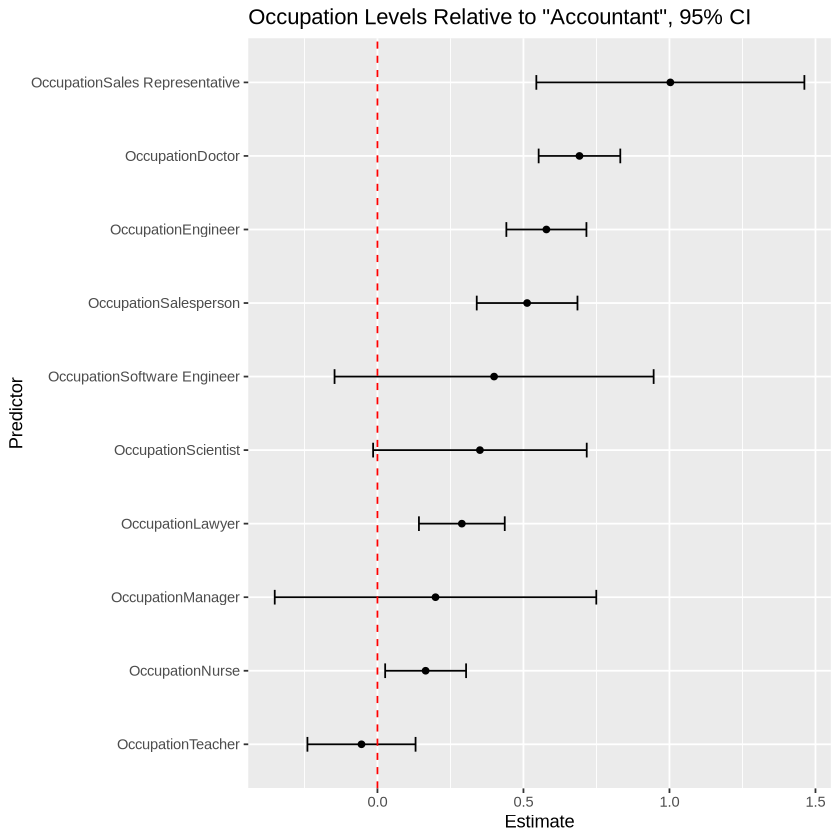

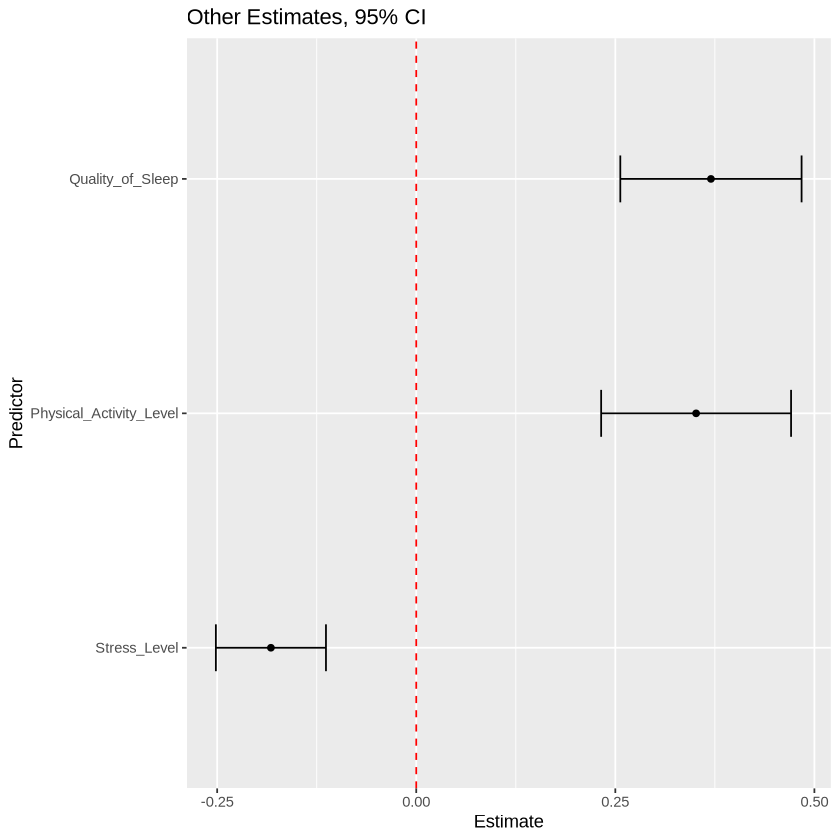

In [10]:
model_results <- tidy(aic_model, conf.int = TRUE) %>%
  filter(term != "(Intercept)") %>%
  mutate(
    direction = ifelse(
      p.value < 0.05,
      ifelse(estimate > 0, "Positive", "Negative"), "Neither"))

occupation_vars <- model_results %>% filter(grepl("^Occupation", term))
numeric_vars <- model_results %>% filter(!grepl("^Occupation", term))

plot_ci <- function(data, title) {
  ggplot(data, aes(x = estimate, y = reorder(term, estimate))) +
    geom_point() +
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
    labs(title = title, x = "Estimate", y = "Predictor")
}

plot_ci(occupation_vars, "Occupation Levels Relative to \"Accountant\", 95% CI")
plot_ci(numeric_vars, "Other Estimates, 95% CI")

These graphs have a clean visualization of the significance of each predictor using mean and CI.

# VALIDATION

Here we start using the test set to validate our stepAIC model.

In [11]:
prediction_test <- predict(aic_model, newdata = sleep_test)
actual <- sleep_test$Sleep_Duration
residual <- actual - prediction_test
RMSE <- sqrt(mean(residual^2))
MAE <- mean(abs(residual))
R2 <- 1 - sum(residual^2) / sum((actual - mean(actual))^2)

print(c(RMSE = RMSE, MAE = MAE, R2 = R2))

mean_sleep <- mean(sleep_test$Sleep_Duration)
relative_RMSE <- RMSE / mean_sleep
relative_MAE <- MAE / mean_sleep

print(paste("RMSE RELATIVE TO MEAN SLEEP DURATION: ", round(relative_RMSE,4)))
print(paste("MAE RELATIVE TO MEAN SLEEP DURATION: ", round(relative_MAE,4)))

     RMSE       MAE        R2 
0.3031200 0.2235853 0.8484668 
[1] "RMSE RELATIVE TO MEAN SLEEP DURATION:  0.0424"
[1] "MAE RELATIVE TO MEAN SLEEP DURATION:  0.0313"


Summary of test-set validation:

- RMS error: about 0.284 hrs sleep duration, or 17 minutes.
- Relative RMSE: about 0.0424, good.
- MA error: 0.215 hrs, or 13 min.
- Relative MAE: about 0.0313, good.
- R^2: 0.872, good.

# extra diagnostics

Warning message:
“not plotting observations with leverage one:
  140, 171”


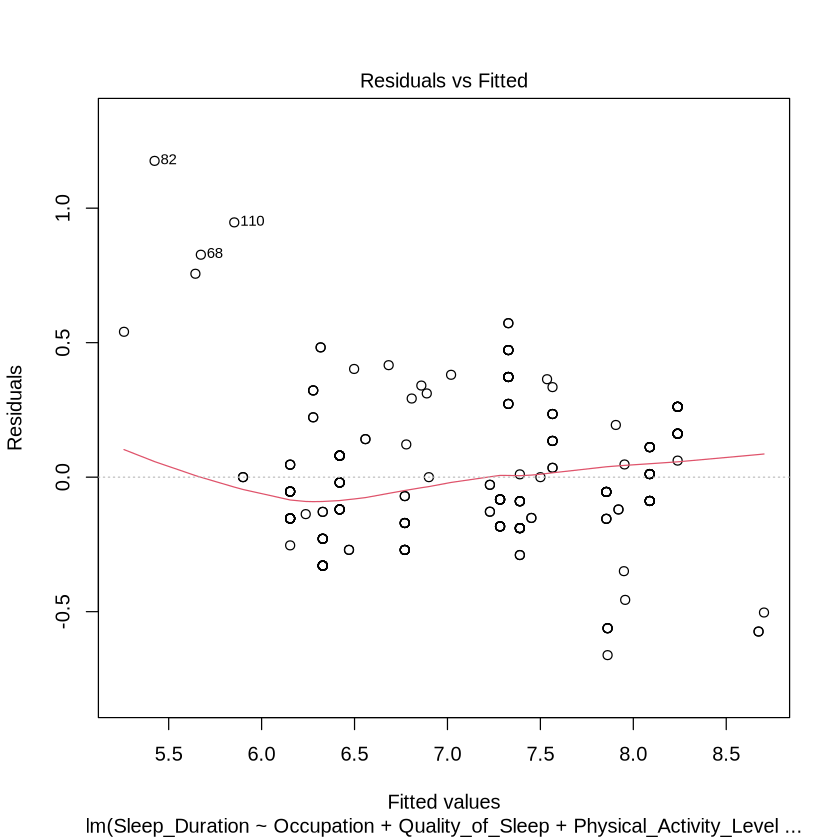

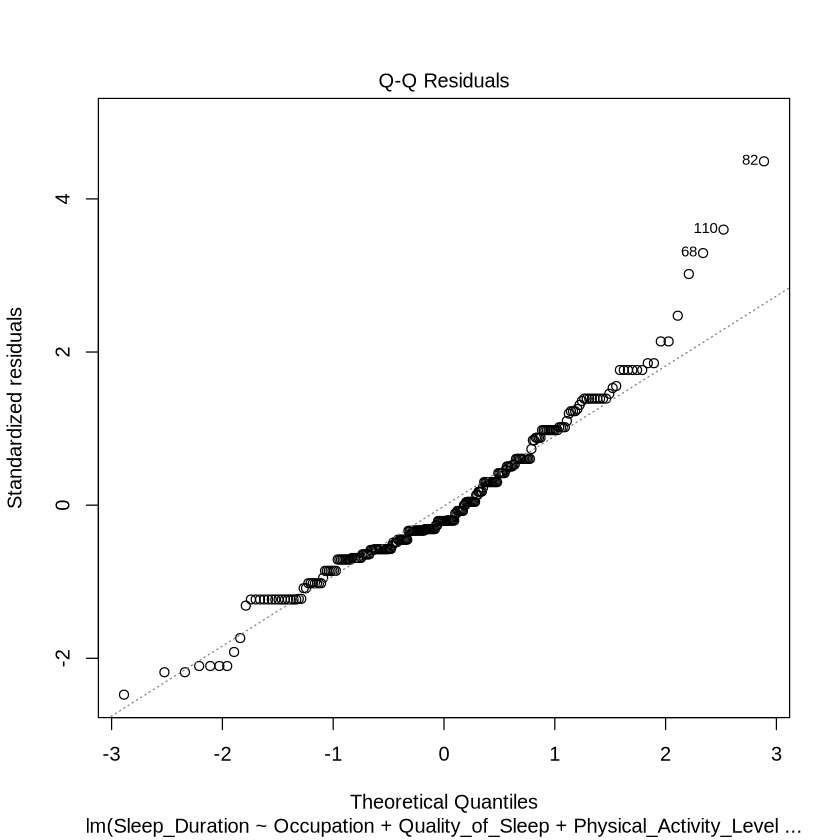

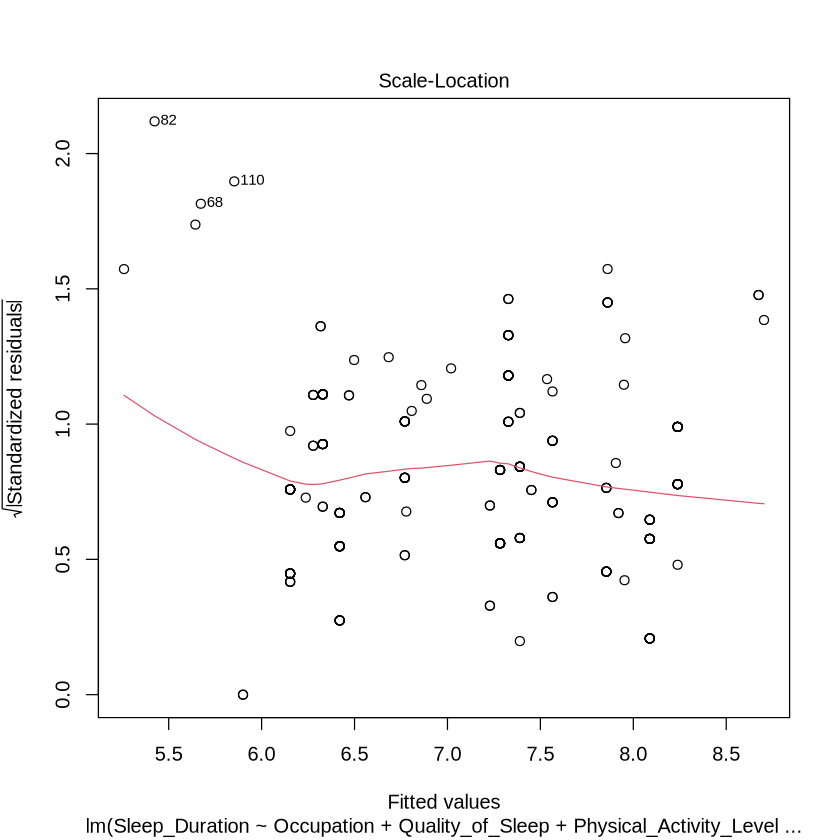

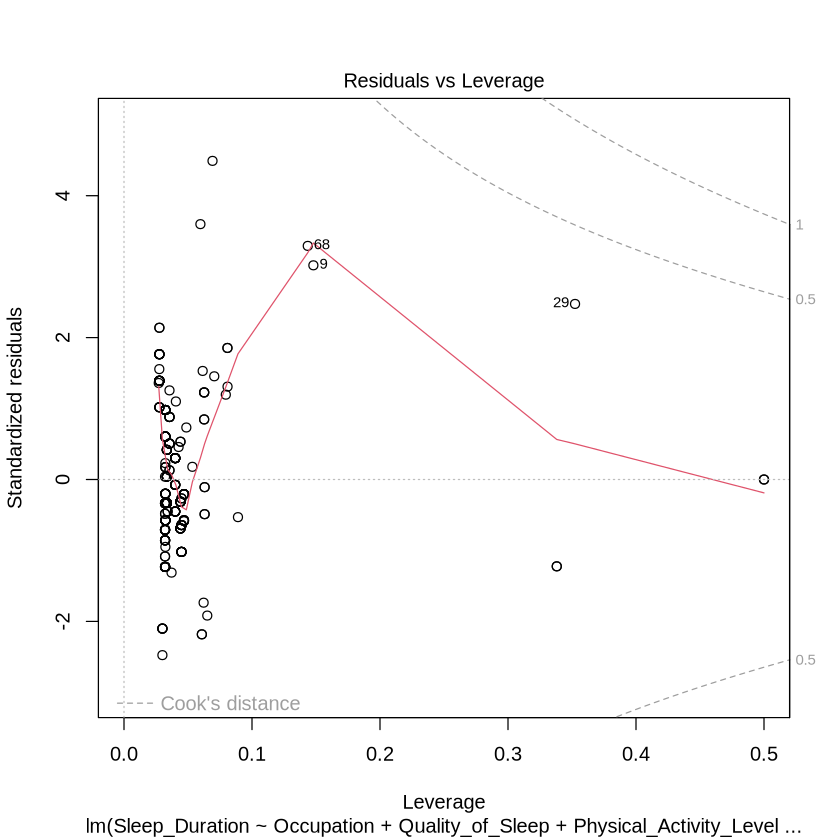

In [12]:
plot(aic_model)  # 4 base plots: residuals, Q-Q, scale-location, leverage